In [1]:
# Test the tool on single-cell rnaseq data from bone marrow 

In [2]:
import flexynesis 
import torch, os
torch.set_num_threads(4)

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


In [3]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 20 # number of HPO iterations for final modeling run

In [7]:
if not os.path.exists("singlecell_bonemarrow"):
    !wget -O singlecell_bonemarrow.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/singlecell_bonemarrow.tgz" && tar -xzvf singlecell_bonemarrow.tgz

--2024-02-28 16:44:37--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/singlecell_bonemarrow.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.47, 141.80.181.46
Connecting to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110733916 (106M) [application/octet-stream]
Saving to: ‘singlecell_bonemarrow.tgz’

singlecell_bonemarr 100%[===================>] 105.60M  64.4MB/s    in 1.6s    

2024-02-28 16:44:39 (64.4 MB/s) - ‘singlecell_bonemarrow.tgz’ saved [110733916/110733916]

singlecell_bonemarrow/
singlecell_bonemarrow/9606.protein.aliases.v12.0.txt
singlecell_bonemarrow/9606.protein.links.v12.0.txt
singlecell_bonemarrow/test/
singlecell_bonemarrow/test/clin.csv
singlecell_bonemarrow/test/ADT.csv
singlecell_bonemarrow/test/RNA.csv
singlecell_bonemarrow/train/
singlecell_bonemarrow/train/ADT.csv
singlecell_bonemarrow/train/RNA.csv
si

In [9]:
data_importer = flexynesis.DataImporter(path ='singlecell_bonemarrow/', 
                                        data_types = ['RNA', 'ADT'], 
                                        concatenate=False, top_percentile=10, min_features=25)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing singlecell_bonemarrow/train/clin.csv...
[INFO] Importing singlecell_bonemarrow/train/RNA.csv...
[INFO] Importing singlecell_bonemarrow/train/ADT.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing singlecell_bonemarrow/test/clin.csv...
[INFO] Importing singlecell_bonemarrow/test/RNA.csv...
[INFO] Importing singlecell_bonemarrow/test/ADT.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame RNA - Removed 1875 features.
[INFO] Number of NA values:  0
[INFO] DataFrame ADT - Removed 0 features.
[INFO] DataFrame RNA - Remov

Filtering redundant features: 100%|██████████| 1513/1513 [00:02<00:00, 637.99it/s]


[INFO] Implementing feature selection using laplacian score for layer: ADT with  25 features
[INFO] No feature selection applied. Returning original matrix. Demanded # of features is  larger than existing number of features

[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame RNA - Removed 1800 features.
[INFO] Number of NA values:  0
[INFO] DataFrame ADT - Removed 0 features.
[INFO] DataFrame RNA - Removed 0 samples (0.00%).
[INFO] DataFrame ADT - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: RNA': 1419, 'feature_count in: ADT': 25, 'sample_count': 1000}
[INFO] Test Data Stats:  {

In [10]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: nCount_RNA
Numerical Variable Summary: Median = 2301.0, Mean = 2942.25
------
Summary for variable: nFeature_RNA
Numerical Variable Summary: Median = 766.0, Mean = 889.524
------
Summary for variable: nCount_ADT
Numerical Variable Summary: Median = 4459.5, Mean = 4546.876
------
Summary for variable: nFeature_ADT
Numerical Variable Summary: Median = 25.0, Mean = 24.887
------
Summary for variable: RNA_weight
Numerical Variable Summary: Median = 0.4011503669288575, Mean = 0.3936306070806877
------
Summary for variable: orig_ident
Categorical Variable Summary:
  Label: bmcite, Count: 1000
------
Summary for variable: lane
Categorical Variable Summary:
  Label: HumanHTO1, Count: 101
  Label: HumanHTO10, Count: 67
  Label: HumanHTO2, Count: 106
  Label: HumanHTO3, Count: 113
  Label: HumanHTO4, Count: 75
  Label: HumanHTO5, Count: 113
  Label: HumanHTO6, Count: 89
  Label: HumanHTO7, Count: 119
  Label: HumanHTO8, Count: 111
  Label: HumanHTO9, Count: 106
------
Summa

In [11]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["celltype_l1"],
                                        config_name = "DirectPred", 
                                        plot_losses=True, early_stop_patience=10, 
                                        n_iter=HPO_ITER)    

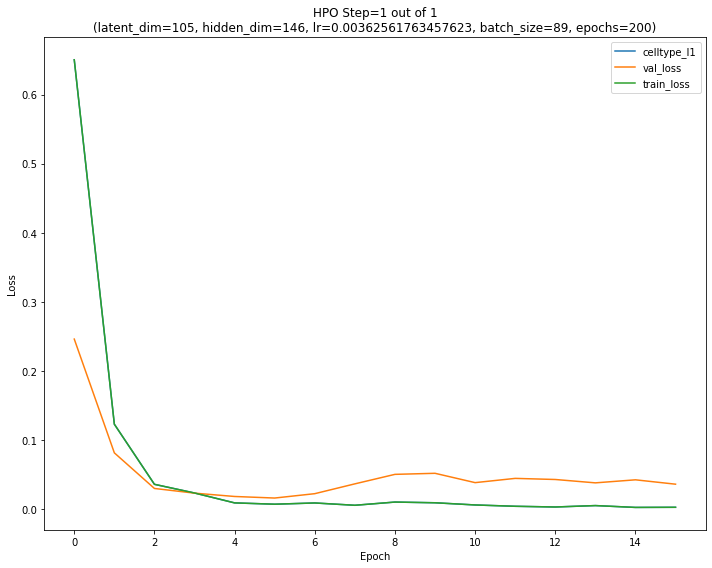

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.016. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        celltype_l1        │    0.03630061447620392    │
│         val_loss          │    0.03630061447620392    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 1/1 [00:08<00:00,  8.34s/it, Iteration=1, Best Loss=0.0363]


In [12]:
model, best_params = tuner.perform_tuning()

In [13]:
model

DirectPred(
  (log_vars): ParameterDict(  (celltype_l1): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1419, out_features=146, bias=True)
      (layer_out): Linear(in_features=146, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(146, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=25, out_features=146, bias=True)
      (layer_out): Linear(in_features=146, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(146, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (celltype_l1): MLP(
      (layer_1): Linear(in_features=210, out_features=146, bias=True)
      (layer_out): Linear(in_features=146, out_features=5, bias=True)
      (relu): 

In [14]:
best_params

{'latent_dim': 105,
 'hidden_dim': 146,
 'lr': 0.00362561763457623,
 'batch_size': 89,
 'epochs': 200}

In [15]:
y_pred_dict = model.predict(test_dataset)

In [16]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,celltype_l1,categorical,balanced_acc,0.965630
1,celltype_l1,categorical,f1_score,0.973345
2,celltype_l1,categorical,kappa,0.976600


In [17]:
ds = test_dataset
E = model.transform(ds)

In [18]:
f = 'celltype_l1'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

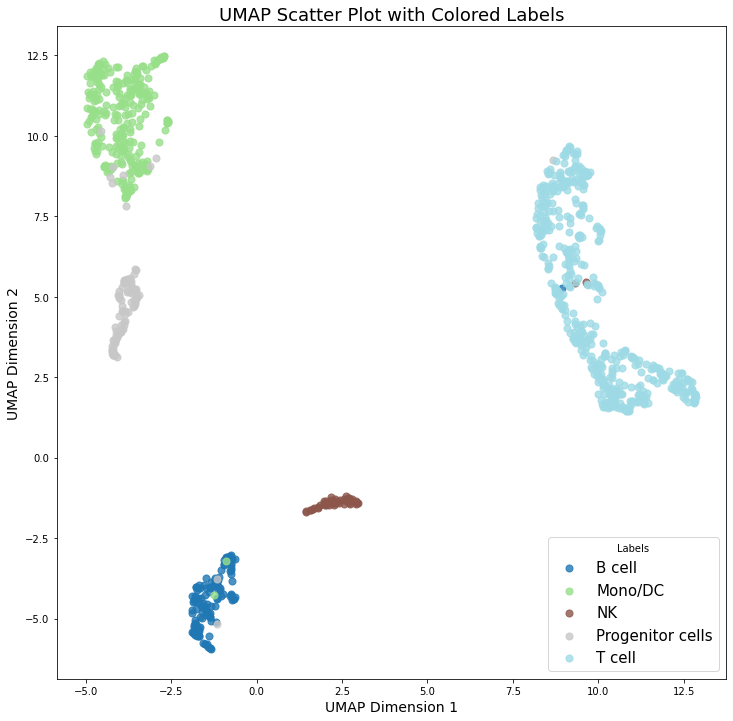

In [19]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':50, 'alpha': 0.8},legend_kwargs={'fontsize': 15}, figsize=(12, 12))

In [20]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 20)

In [21]:
top_features = flexynesis.get_important_features(model, f, top=2)

In [23]:
my_dict = train_dataset.label_mappings['celltype_l1']
my_list = top_features['target_class']
top_features['target_class_label'] = [my_dict.get(item) for item in my_list if item in my_dict]
top_features

,target_variable,target_class,layer,name,importance,target_class_label
0,celltype_l1,0,ADT,CD19,0.662994,B cell
1,celltype_l1,0,ADT,CD45RA,0.477605,B cell
2,celltype_l1,1,ADT,CD14,0.486517,Mono/DC
3,celltype_l1,1,ADT,CD11c,0.394333,Mono/DC
4,celltype_l1,2,ADT,CD161,0.267081,NK
5,celltype_l1,2,ADT,CD45RA,0.255129,NK
6,celltype_l1,3,ADT,HLA.DR,0.301809,Progenitor cells
7,celltype_l1,3,ADT,CD34,0.235881,Progenitor cells
8,celltype_l1,4,ADT,CD8a,0.486414,T cell
9,celltype_l1,4,ADT,CD3,0.450259,T cell
